In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from bs4 import BeautifulSoup

%matplotlib inline

### Importing the datasets 

In [2]:
#RateBeer and Beer Advocate matched website data :

df_beer = pd.read_csv("matched_beer_data/beers.csv", header=1)
df_breweries  = pd.read_csv("matched_beer_data/breweries.csv", header=1)
df_users = pd.read_csv("matched_beer_data/users.csv", header=1)
df_rating = pd.read_csv("matched_beer_data/ratings.csv", header=1)
df_users_approx = pd.read_csv("matched_beer_data/users_approx.csv", header=1)

#Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')


### Data preprocessing:

**IMPORTING NEW DATASET ABOUT THE LOCATIONS'SUPERFICIES AND CLEANING THEM**

In [3]:
#wikipedia dataset for states (US) superficies
wiki_url_4usa = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area'
#Get the html of the pages
response_us = requests.get(wiki_url_4usa)
soup_us = BeautifulSoup(response_us.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list_us = soup_us.find('table', attrs={'class':"wikitable"})
df_superficies_us = pd.read_html(str(superficies_list_us), header=1)[0]
display(df_superficies_us.columns)

#Clean the datafram
df_superficies_us = df_superficies_us[['State', 'km2']] #Keep only the columns we need
df_superficies_us['State'] = 'United States, ' + df_superficies_us['State'] #add the country name to be consistent with the other dataset
df_superficies_us = df_superficies_us.rename(columns={'State': 'location'}) #rename the column
df_superficies_us = df_superficies_us[:-3] #remove the last 3 rows (not states)
df_superficies_us['km2'] = df_superficies_us['km2'].astype(float) #convert the km2 column to int

#_______________________________________________________________________________________________________________________

#wikipedia dataset for country superficies
wiki_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'

#Get the html of the pages
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list = soup.find('table',attrs={'class':"wikitable"})
df_superficies = pd.read_html(str(superficies_list))[0]
display(df_superficies.columns)


#Keep only the columns we need and clean them
df_superficies = df_superficies[['Country / dependency', 'Total in km2 (mi2)']]
df_superficies.rename(columns={'Country / dependency':'location', 'Total in km2 (mi2)':'km2'}, inplace=True) #rename the columns
df_superficies['km2'] = df_superficies['km2'].str.replace(',', '') #remove the comma
df_superficies['km2'] = df_superficies['km2'].str.split(' ').str[0]  #remove the text in parenthesis (mi2)
df_superficies['location'] = df_superficies['location'].str.replace(r'\s*\([^)]*\)', '', regex=True)  #Remove all parenthesis and text inside in the location (ex : remove (China) in 'Hong Kong (China)')
df_superficies['km2'] = df_superficies['km2'].astype(float) #convert the km2 column to int

#Change the name of the countries to be consistent with the other dataset
df_superficies.location = df_superficies.location.replace({'Slovakia' : 'Slovak Republic', 'North Macedonia' : 'Macedonia', 'Trinidad and Tobago' : 'Trinidad & Tobago'})

#________________________________________________________________

#Dataset for UK coutries superficies to be consistent with the other dataset (breweries and beers)
df_superficies_uk = pd.DataFrame({'location': ['England', 'Scotland', 'Wales', 'Northern Ireland'], 
                                  'km2': [130279, 78772, 20779, 14130]}) #create the dataframe (small so easy to do it manually)

#_______________________________________________________________________________________________________________________

#Concatenate the two first dataframe 
df_superficies_temp = pd.concat([df_superficies, df_superficies_us]) #concatenate the two dataframe
print(np.shape(df_superficies_temp))

#Merging the dataframes with the UK dataframe
df_superficies_tot = pd.concat([df_superficies_temp, df_superficies_uk])
print(np.shape(df_superficies_tot))

C:\Users\nicol\AppData\Local\Temp\ipykernel_18448\3756883540.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_superficies_us = pd.read_html(str(superficies_list_us), header=1)[0]


Index(['State', 'Rank', 'sq mi', 'km2', 'Rank.1', 'sq mi.1', 'km2.1', '% land',
       'Rank.2', 'sq mi.2', 'km2.2', '% water'],
      dtype='object')

C:\Users\nicol\AppData\Local\Temp\ipykernel_18448\3756883540.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_superficies = pd.read_html(str(superficies_list))[0]


Index(['Unnamed: 0', 'Country / dependency', 'Total in km2 (mi2)',
       'Land in km2 (mi2)', 'Water in km2 (mi2)', '% water', 'Unnamed: 6'],
      dtype='object')

(323, 2)
(327, 2)


**MERGING, CLEANING AND VISUALIZE THE MATCHED DATASETS (BEERS AND BREWERIES)**

In [4]:
#Merge the two dataframes on the brewery_id column with respect to the beers to have access to the location of every beer
df_beer_breweries = pd.merge(df_beer, df_breweries, left_on='brewery_id', right_on='id', how='left')

#Clean the dataframe by dropping the columns that are not useful for the analysis
df_beer_breweries_clean = df_beer_breweries.drop(['beer_wout_brewery_name', 'beer_wout_brewery_name.1', 'style','abv.1', 'id', 'id.1', 'name', 'name.1', 'beer_name.1', 'brewery_name.1', 'location.1', 'nbr_beers.1'], axis=1)


#Choose to keep style from RateBeer and drop the style from Beer Advocate (the style from Beer Advocate is too precise)
df_beer_breweries_clean.rename(columns={'style.1':'style'}, inplace=True)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

In [5]:
#Visualization of the dataframe computed above

tmp = df_beer_breweries_clean.groupby('location').size().reset_index(name='count')
new = df_beer_breweries_clean.groupby('location').avg.mean().reset_index().dropna()

# To fit the state names, we need to rename some of them by removing the country name
new.location = new.location.str.replace('United States, ', '')

#add the count column to the new df
new = pd.merge(new, tmp, on='location', how='left')
#new = new[new['count'] > 5]

#plotly doesn't recognise mauritius so we drop it and we need to add the correct names for the UK countries
new = new[new['location'] != 'Mauritius']
new.location = new.location.replace({'England': 'GB-ENG', 'Scotland': 'GB-SCT', 'Wales': 'GB-WLS', 'Northern Ireland': 'GB-NIR'})


# Replace full state names with abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
    'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }
new['location'] = new['location'].map(state_abbreviations).fillna(new['location'])

#sort new df by avg
new = new.sort_values(by=['avg'], ascending=False)

display(new)

,location,avg,count
54,Ivory Coast,4.440000,1.0
14,Cameroon,4.280000,1.0
161,Uruguay,4.080000,1.0
42,Grenada,4.000000,2.0
129,ME,3.943314,NaN
...,...,...,...
64,Malawi,2.090000,3.0
29,Egypt,2.020000,4.0
0,Albania,1.830000,1.0
59,Lebanon,1.670000,2.0


In [6]:
# Create a world map
#Problem to show the countries from the UK on the map
fig_world = px.choropleth(new, locations='location',
                          locationmode='country names', 
                          color='avg', 
                          hover_name='location', 
                          color_continuous_scale=px.colors.sequential.Plasma,
                          scope='world',
                          projection = 'orthographic') 

fig_world.show()

# Create a USA map
fig_usa = px.choropleth(new, locations='location',
                         locationmode='USA-states', 
                         color='avg', 
                         hover_name='location', 
                         color_continuous_scale=px.colors.sequential.Plasma,
                         scope='usa') 

fig_usa.show()

**MERGING AND CLEANING THE MATCHED DATASETS (SUPERFICIES AND BREWERIES)**

In [7]:
#Merge the dataframe with the superficies dataframe to have access to the superficies of every beer
print(df_superficies_tot.shape)
df_breweries_superficies = pd.merge(df_breweries, df_superficies_tot, on='location', how='left')
print(df_breweries_superficies.shape)

#Drop row with NaN values in km2 column
df_breweries_superficies = df_breweries_superficies.dropna(subset=['km2'])
print(df_breweries_superficies.shape)

#Drop the location with less than 5 breweries (to do a beer trip, we need to have different breweries to visit!)
df_breweries_superficies_flt = df_breweries_superficies.groupby('location').filter(lambda x: len(x) >= 5)
print(df_breweries_superficies_flt.shape)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

(327, 2)
(8535, 11)
(8529, 11)
(8365, 11)


In [43]:
df_breweries_superficies_flt

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim,km2
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062,14130.0
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596,14130.0
2,40360,Northern Ireland,Walled City Brewing Company,6,24866,Northern Ireland,Walled City,3,0.527852,0.954183,14130.0
3,40309,Northern Ireland,Ards Brewing Company,7,13538,Northern Ireland,Ards Brewing Co.,13,0.554395,0.896098,14130.0
4,41205,Northern Ireland,Barrahooley Brewery,3,22304,Northern Ireland,Barrahooley Craft Brewery,4,0.602544,0.896205,14130.0
...,...,...,...,...,...,...,...,...,...,...,...
8529,10673,"United States, Indiana",Warbird Brewing Company,6,5358,"United States, Indiana",Warbird Brewing Company,6,0.658297,1.000000,94326.0
8530,34365,France,Brasserie De La Goutte D'Or,0,16083,France,Goutte dOr,24,0.412731,0.848934,643801.0
8531,34365,France,Brasserie De La Goutte D'Or,0,16083,France,Goutte dOr,24,0.412731,0.848934,543940.0
8532,23693,South Africa,Luyt Brewery,0,13836,South Africa,Luyt Brewery,1,0.706339,1.000000,1221037.0


**CLEANING THE DATASET ABOUT USERS**

This part is not finish yet, we need to merge it with the dataframe imported from Wikipedia with the population of the locations, because the goal of this preprocessing is to express finally the places where there are the biggest amount of "expert" per capita. 

In [8]:
#Selection of the columns to keep and rename them
df_users_approx_flt = df_users_approx[['location', 'user_id', 'user_name', 'nbr_ratings', 'nbr_ratings.1']]
df_users_approx_flt = df_users_approx_flt.rename(columns={'nbr_ratings':'nbr_ratings_beer_advocate', 'nbr_ratings.1':'nbr_ratings_ratebeer'})


#Check that every user has at least one rating in each website (insure that the user is active)
df_users_approx_flt = df_users_approx_flt.drop(df_users_approx_flt[(df_users_approx_flt['nbr_ratings_beer_advocate'] == 0) | (df_users_approx_flt['nbr_ratings_ratebeer'] == 0)].index)  # Drop rows where there is no ratings in one of the two websites


**CREATED, CLEANED AND VISUALIZED DATAFRAME FOR THE CONNOISSEUR TRIP**

In [9]:
#POUR LA PARTIE DE NIKO : PS : rajoute la partie on tu fera des calculs apres ma partie sur les ratings, ca fait plus sens


*ALL OF THE FEATURES USED TO BUILD THE TRIPS*


|Name | Object  | Description   |
| -------- | -------- | -------- |
| *df_beer_breweries_clean* | DataFrame | filtered dataset with both beer and breweries data|
|  abv  | Series - float  | Indicates the beer's alcohol percentage|
|  avg  | Series - float  | Average score given to the beer |
|  avg_computed -float | Series - float  ||
|  avg_matched_valid_ratings | Series - float  ||
|  ba_score  | Series - float  ||
|  beer_id  | Series - int  | Unique ID of each beer|
|  beer_name  | Series - string  | Name of the beer |
|  brewery_id  | Series - int  | Unique ID for each brewery the beers belong to|
|  brewery_name  | Series - string  | Name of the brewery|
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||
|    | Series   ||

### Start to build our different trips :

**BREWERIES PER KM2**

location
Argentina                   2780400.0
Australia                   7692024.0
Austria                       83871.0
Belgium                       30689.0
Brazil                      8515767.0
                              ...    
United States, Wisconsin     169635.0
United States, Wyoming       253335.0
Uzbekistan                   448978.0
Vietnam                      331212.0
Wales                         20779.0
Name: km2, Length: 111, dtype: float64

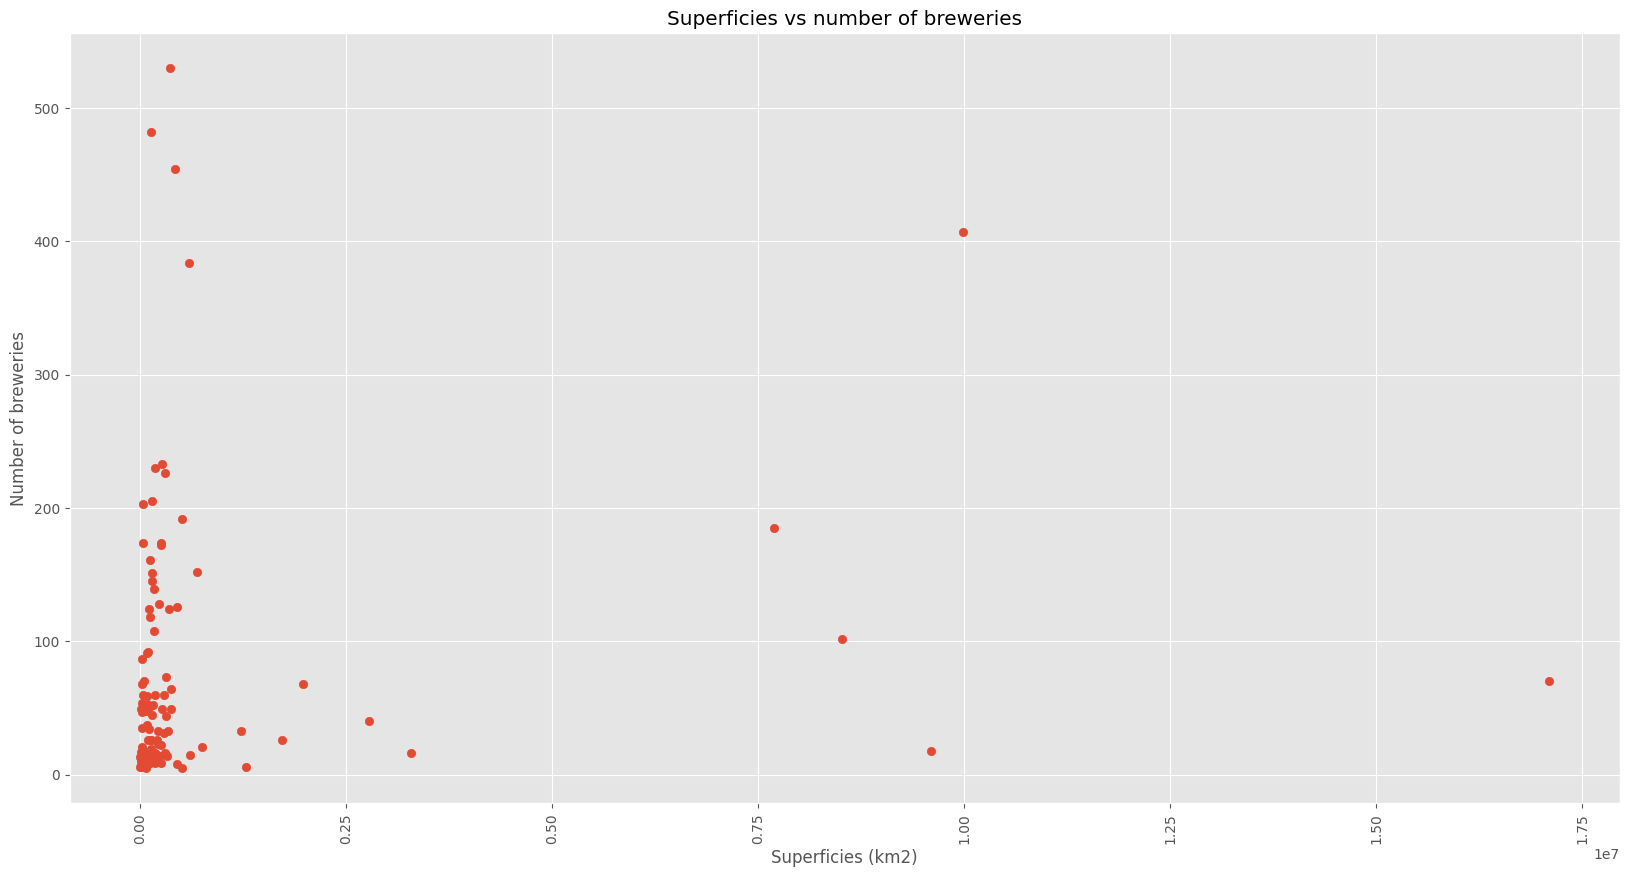

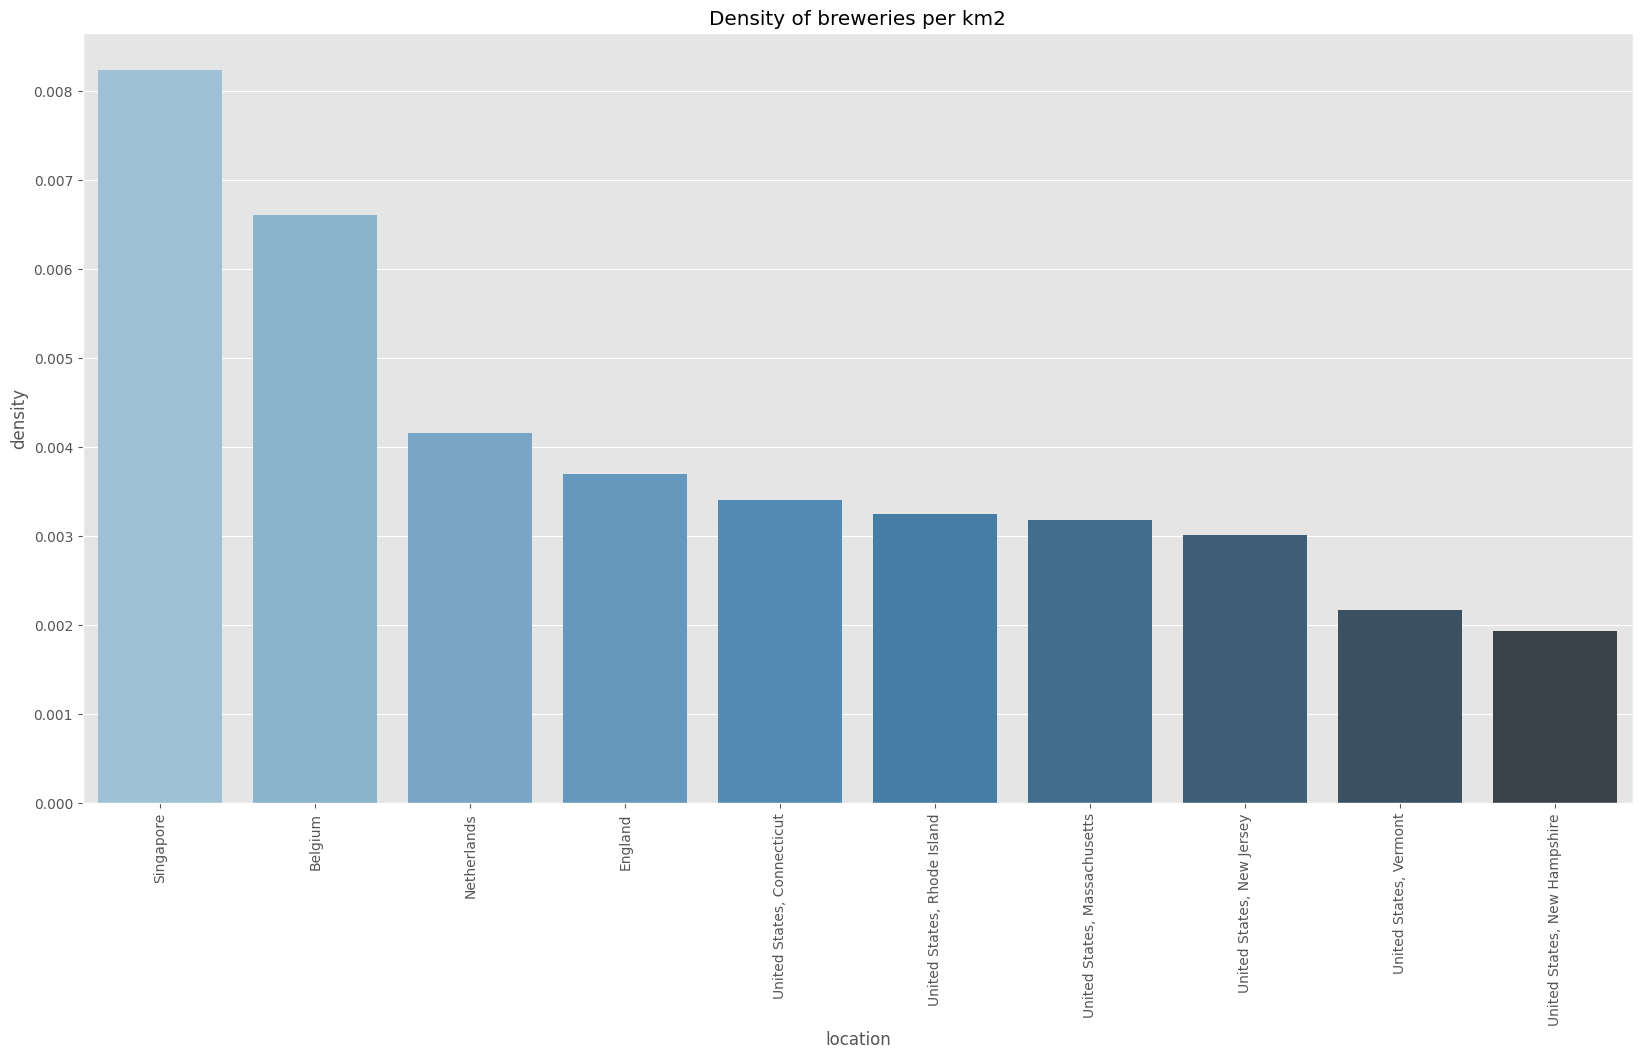

In [47]:
#Group the breweries by country, count the number of breweries and divide by the superfices of the location to have a density :
df_breweries_superficies_count = df_breweries_superficies_flt.groupby(['location']).id.count()
#display(df_breweries_superficies_flt)

#Get the values of the km2 in every location 
df_breweries_superficies_km2 = df_breweries_superficies_flt.groupby(['location']).km2.mean()
display(df_breweries_superficies_km2)

#Plot with superficies vs number of breweries
plt.figure(figsize=(20,10))
plt.scatter(df_breweries_superficies_km2, df_breweries_superficies_count)
plt.xlabel('Superficies (km2)')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.title('Superficies vs number of breweries')
plt.show()

#Concatenate the two dataframe to have access to the density of breweries per km2
df_density = pd.concat([df_breweries_superficies_count, df_breweries_superficies_km2], axis=1)
df_density['density'] = df_density['id'] / df_density['km2']
df_density.reset_index(inplace=True)
df_density.sort_values(by=['density'], ascending=False, inplace=True) 
top_ten_density = df_density.head(10)

#Plot the density of breweries per km2
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('Density of breweries per km2')
sns.barplot(x='location', y='density', data=top_ten_density, palette='Blues_d', hue='location')
plt.show()

#Store the location of the top 10 density of breweries per km2
top_ten_density_location = top_ten_density['location']

#NO error bar because we don't have the standard deviation of the density of breweries per km2....



**THE PERCENTAGE OF ALCOHOL**

In [11]:
#Drop the location with less than 5 beers (to do a beer trip, we need to have different beer to drink!) and beer with less than 20 ratings
df_beer_breweries_flt_abv = df_beer_breweries_clean.groupby('location').filter(lambda x: (len(x) >= 5) | (x['nbr_ratings'].sum() + x['nbr_ratings.1'].sum() >= 20)) 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Trinidad & Tobago,8.0,3.525000,1.971765,1.2,1.200,4.45,5.050,5.5
Bosnia and Herzegovina,3.0,3.666667,1.457166,2.0,3.150,4.30,4.500,4.7
Albania,1.0,4.100000,NaN,4.1,4.100,4.10,4.100,4.1
Jersey,5.0,4.100000,0.264575,3.7,4.000,4.20,4.200,4.4
Cuba,2.0,4.250000,0.353553,4.0,4.125,4.25,4.375,4.5
Lebanon,2.0,4.350000,2.333452,2.7,3.525,4.35,5.175,6.0
Malawi,3.0,4.466667,1.078579,3.7,3.850,4.00,4.850,5.7
Uzbekistan,12.0,4.475000,0.601702,3.4,4.225,4.40,5.000,5.4
Isle of Man,4.0,4.650000,1.297433,3.7,3.775,4.20,5.075,6.5


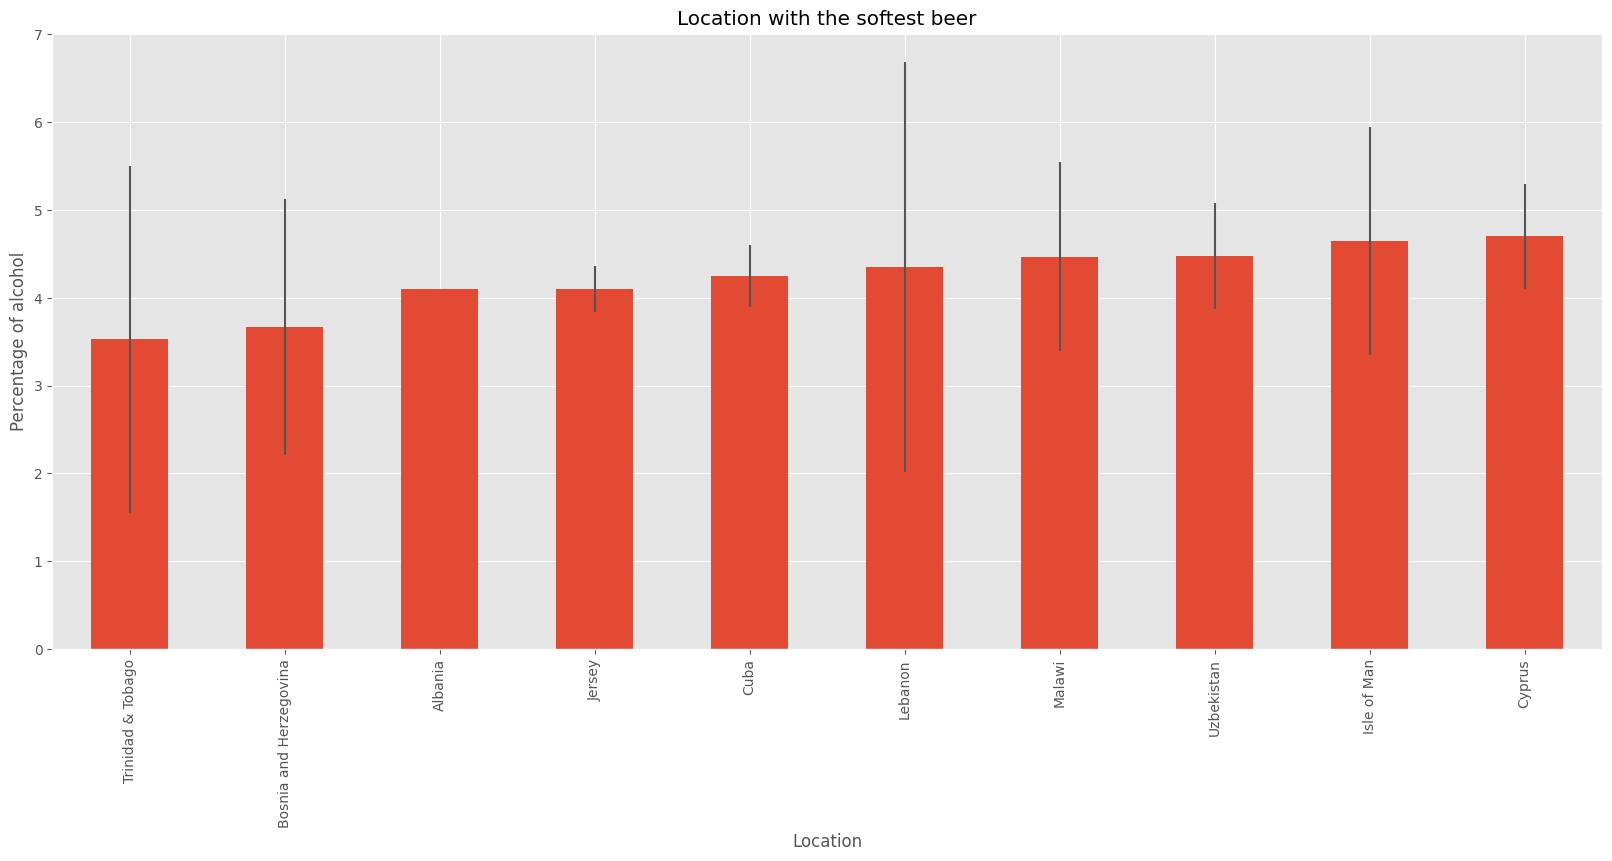

In [12]:
#Sort the dataframe by considering the 10 location with the softest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_abv_soft = avg_rating_location.head(10)
display(top_ten_abv_soft)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_soft['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_soft['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the softest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_soft.index, rotation=90)


#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_soft.index 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Egypt,4.0,7.675000,2.736634,4.7,5.675,8.00,10.000,10.0
Estonia,69.0,7.482609,2.704080,3.8,5.500,6.90,8.900,16.0
Belgium,863.0,7.115435,2.328768,0.5,6.000,7.00,8.000,39.0
Iceland,45.0,7.108889,2.644619,4.0,5.200,6.00,9.000,14.5
"United States, Rhode Island",143.0,7.013566,2.198081,2.5,5.500,6.60,8.000,12.5
Netherlands,569.0,7.005290,2.022058,0.5,5.600,6.60,8.200,20.0
"United States, Oklahoma",90.0,6.880000,2.655933,3.7,5.075,6.25,8.000,17.0
"United States, Georgia",461.0,6.852278,1.906642,3.0,5.300,6.50,8.100,13.9
Mauritius,12.0,6.825000,2.100271,4.8,5.600,6.20,7.375,12.0


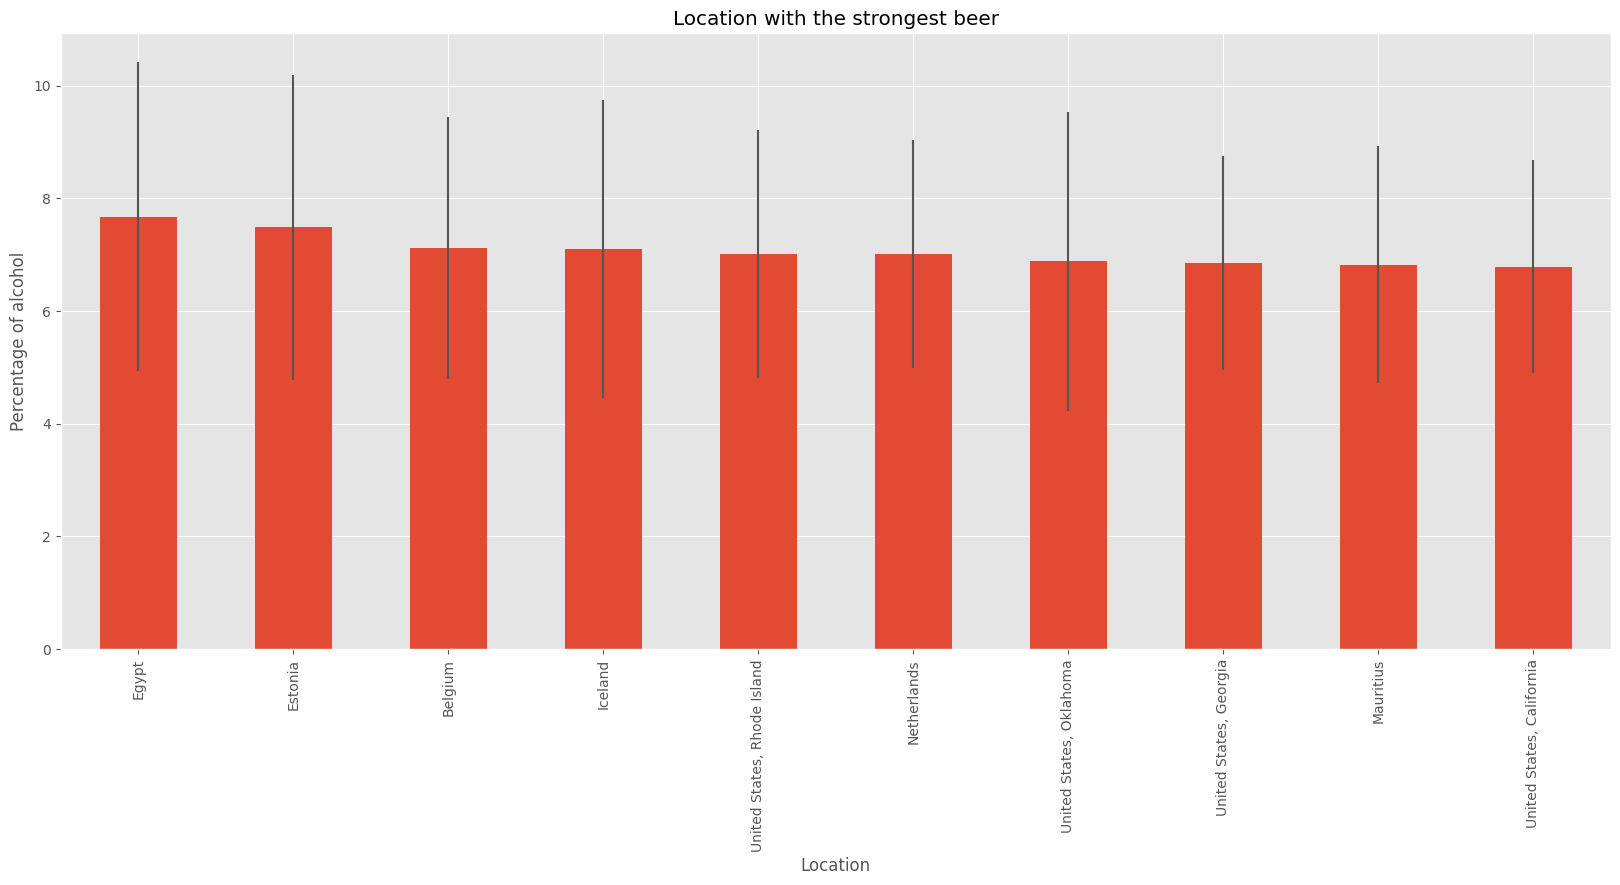

In [13]:
#Sort the dataframe by considering the 10 location with the strongest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_abv_strong = avg_rating_location.head(10)
display(top_ten_abv_strong)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_strong['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_strong['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the strongest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_strong.index, rotation=90)

#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_strong.index 


**THE RATINGS IN GLOBAL**

(162, 30)


[Text(0, 0, 'Albania'),
 Text(1, 0, 'Algeria'),
 Text(2, 0, 'Angola'),
 Text(3, 0, 'Argentina'),
 Text(4, 0, 'Australia'),
 Text(5, 0, 'Austria'),
 Text(6, 0, 'Bahamas'),
 Text(7, 0, 'Belarus'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Bhutan'),
 Text(10, 0, 'Bosnia and Herzegovina'),
 Text(11, 0, 'Brazil'),
 Text(12, 0, 'Bulgaria'),
 Text(13, 0, 'Cambodia'),
 Text(14, 0, 'Cameroon'),
 Text(15, 0, 'Canada'),
 Text(16, 0, 'Cape Verde Islands'),
 Text(17, 0, 'Cayman Islands'),
 Text(18, 0, 'Chile'),
 Text(19, 0, 'China'),
 Text(20, 0, 'Colombia'),
 Text(21, 0, 'Cook Islands'),
 Text(22, 0, 'Costa Rica'),
 Text(23, 0, 'Croatia'),
 Text(24, 0, 'Cuba'),
 Text(25, 0, 'Cyprus'),
 Text(26, 0, 'Czech Republic'),
 Text(27, 0, 'Denmark'),
 Text(28, 0, 'Egypt'),
 Text(29, 0, 'El Salvador'),
 Text(30, 0, 'England'),
 Text(31, 0, 'Eritrea'),
 Text(32, 0, 'Estonia'),
 Text(33, 0, 'Faroe Islands'),
 Text(34, 0, 'Finland'),
 Text(35, 0, 'France'),
 Text(36, 0, 'French Polynesia'),
 Text(37, 0, 'Georgia'),


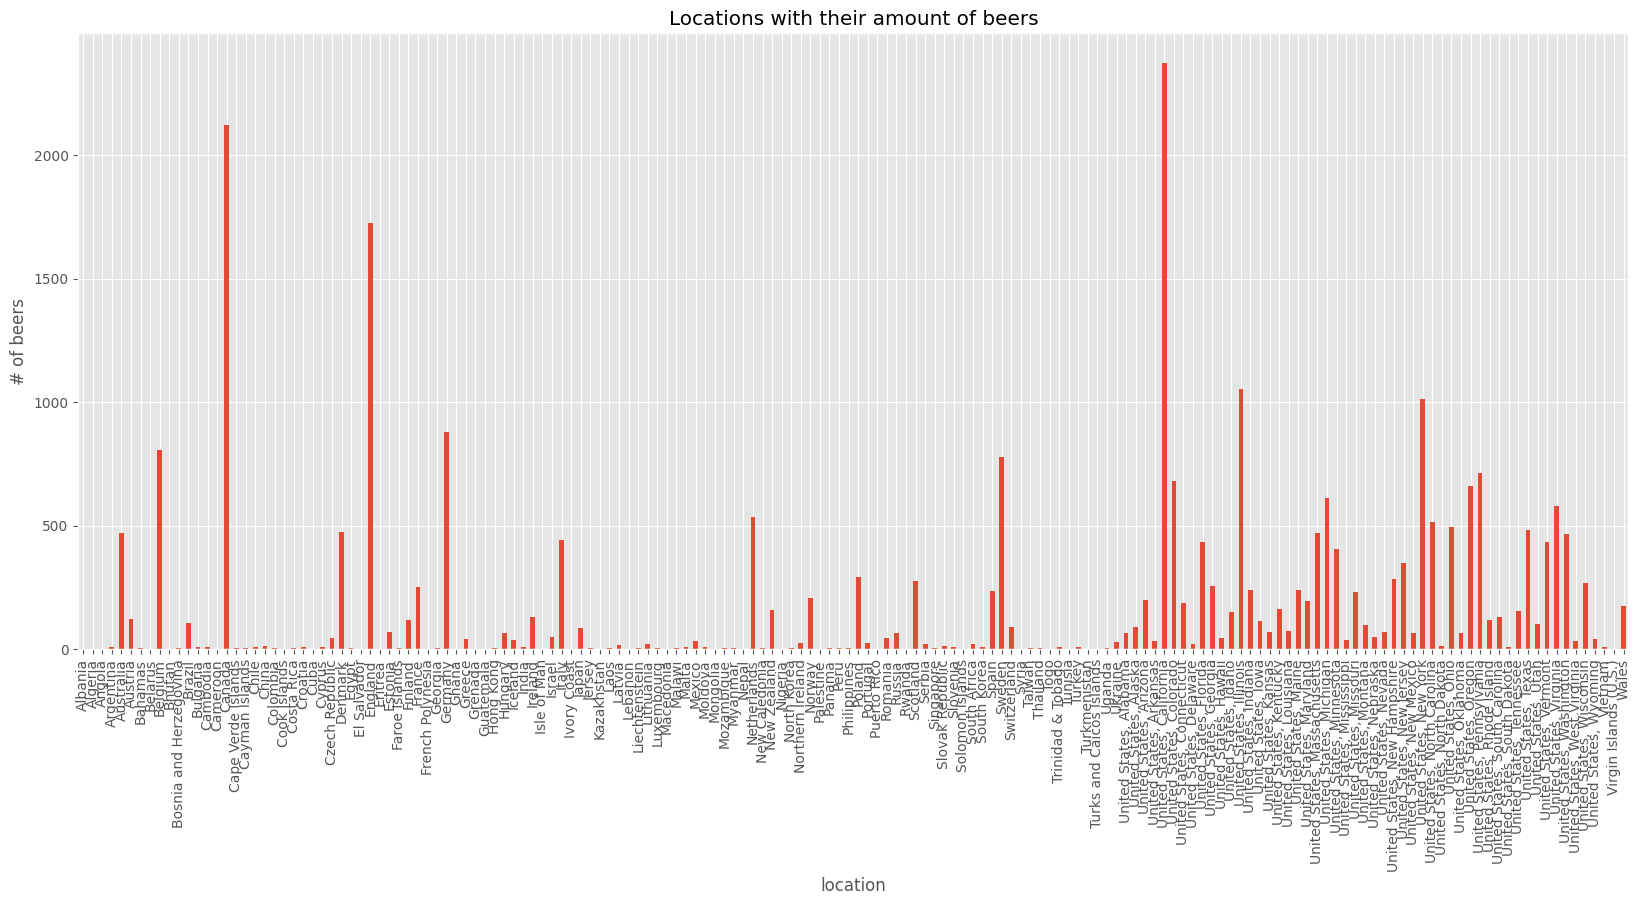

In [37]:
#Select only the beers with at least 5 ratings on either sites (RateBeer and Beer Advocate), because we want to have a good idea of the quality of the beers: 
df_beer_breweries_clean_5_plus = df_beer_breweries_clean[(df_beer_breweries_clean['nbr_ratings'] >=5) | (df_beer_breweries_clean['nbr_ratings.1'] >=5)]

#Grouped the beers by location and count the number of beers in each location
df_beer_breweries_clean_5_plus_4plot = df_beer_breweries_clean_5_plus.groupby(['location']).count()
print(df_beer_breweries_clean_5_plus_4plot.shape)

#Plot the location with the most beers with at least 5 ratings on each sites
pl = df_beer_breweries_clean_5_plus_4plot['beer_name'].plot(kind='bar', figsize=[20,8])
pl.set_title('Locations with their amount of beers')
pl.set_ylabel('# of beers')
pl.set_xlabel('location')
pl.set_xticklabels(df_beer_breweries_clean_5_plus_4plot.index, rotation=90)


We can see on the previous graph that we still have a lot of location to visit after keeping only the beers with more than 5 ratings on both websites, but we can restrain even more this number by imposing conditions on the minimum amount of beers in a location to be considered as a potential destination for the trip. 

(112, 30)


[Text(0, 0, 'Albania'),
 Text(1, 0, 'Algeria'),
 Text(2, 0, 'Angola'),
 Text(3, 0, 'Argentina'),
 Text(4, 0, 'Australia'),
 Text(5, 0, 'Austria'),
 Text(6, 0, 'Bahamas'),
 Text(7, 0, 'Belarus'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Bhutan'),
 Text(10, 0, 'Bosnia and Herzegovina'),
 Text(11, 0, 'Brazil'),
 Text(12, 0, 'Bulgaria'),
 Text(13, 0, 'Cambodia'),
 Text(14, 0, 'Cameroon'),
 Text(15, 0, 'Canada'),
 Text(16, 0, 'Cape Verde Islands'),
 Text(17, 0, 'Cayman Islands'),
 Text(18, 0, 'Chile'),
 Text(19, 0, 'China'),
 Text(20, 0, 'Colombia'),
 Text(21, 0, 'Cook Islands'),
 Text(22, 0, 'Costa Rica'),
 Text(23, 0, 'Croatia'),
 Text(24, 0, 'Cuba'),
 Text(25, 0, 'Cyprus'),
 Text(26, 0, 'Czech Republic'),
 Text(27, 0, 'Denmark'),
 Text(28, 0, 'Egypt'),
 Text(29, 0, 'El Salvador'),
 Text(30, 0, 'England'),
 Text(31, 0, 'Eritrea'),
 Text(32, 0, 'Estonia'),
 Text(33, 0, 'Faroe Islands'),
 Text(34, 0, 'Finland'),
 Text(35, 0, 'France'),
 Text(36, 0, 'French Polynesia'),
 Text(37, 0, 'Georgia'),


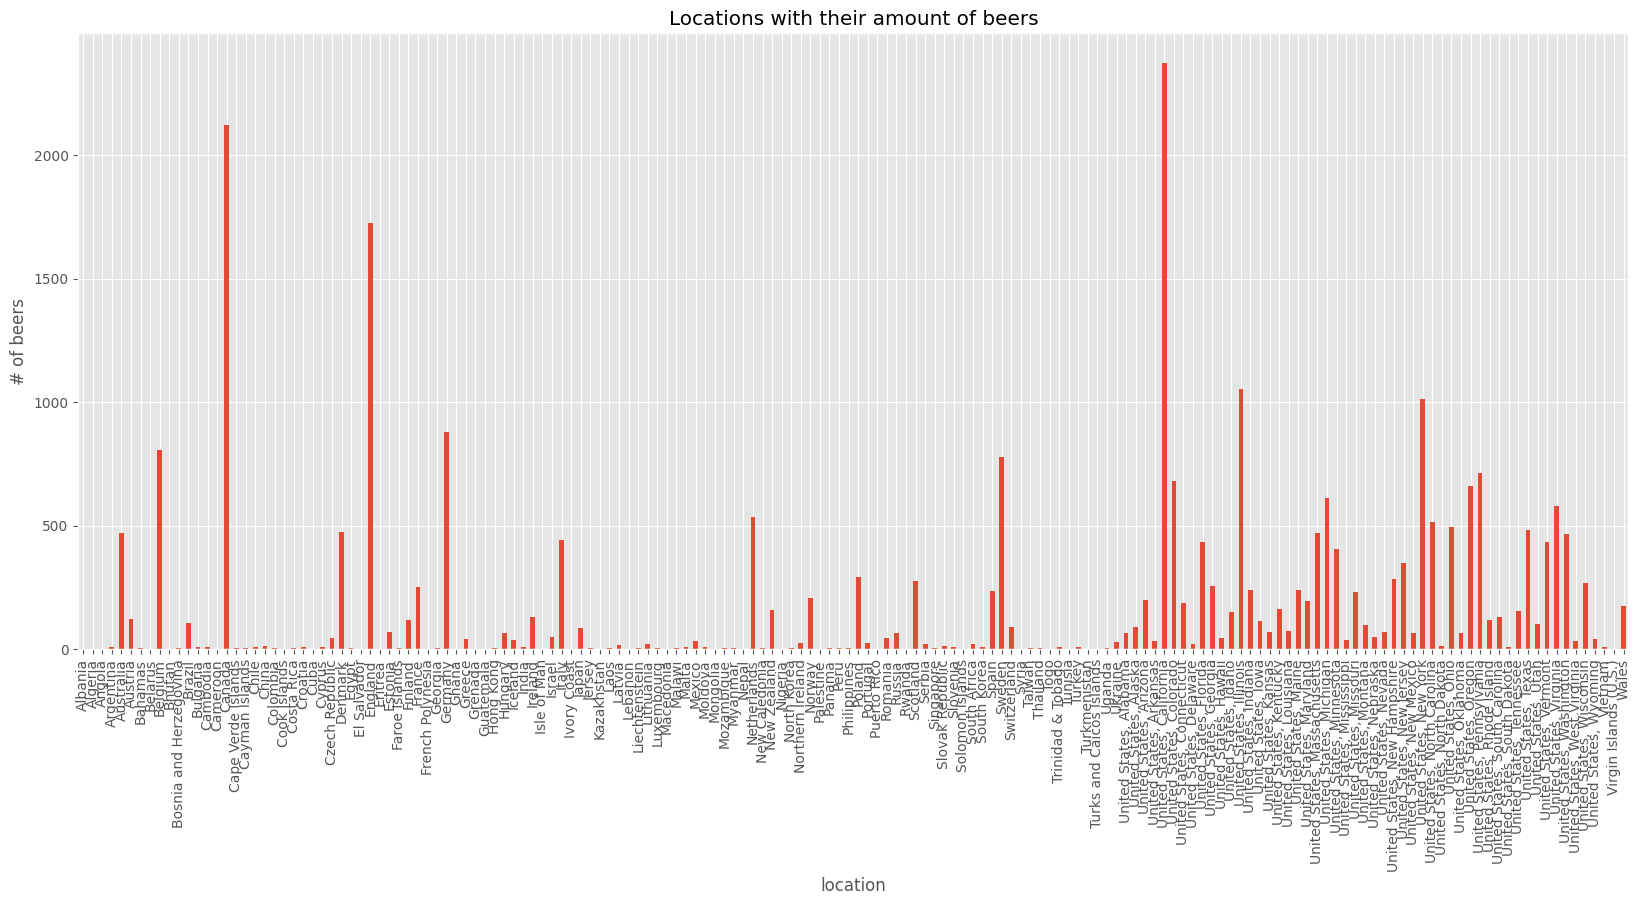

In [36]:
#Drop the beers with no zscore in either sites
df_beer_breweries_clean_5_plus = df_beer_breweries_clean_5_plus.drop(df_beer_breweries_clean_5_plus[(df_beer_breweries_clean_5_plus['zscore'].isna()) | (df_beer_breweries_clean_5_plus['zscore.1'].isna())].index)

#Drop the location with less than 5 beers (to do a beer trip, we need to have different beer to drink!)
df_beer_breweries_flt = df_beer_breweries_clean_5_plus.groupby('location').filter(lambda x: len(x) >= 5)

#Plot the location with more than 5 beers produced and with at least 5 ratings on each sites
pl = df_beer_breweries_clean_5_plus_4plot['beer_name'].plot(kind='bar', figsize=[20,8])
pl.set_title('Locations with their amount of beers')
pl.set_ylabel('# of beers')
pl.set_xlabel('location')
pl.set_xticklabels(df_beer_breweries_clean_5_plus_4plot.index, rotation=90)


We still have 112 destinations for our trip. It is a good number to start with! Now lets analysis the data relatively to the ratings and the best way is to analyse the zscore of the beers. Indeed, the z-score basically makes the ratings comparable both across websites and time in general. However, in order to have a representative overall zscore, we will average the ones from BeerAdvocate and Rate Beer by taking into account their amount of ratings. 

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
"United States, Maine",231.0,0.183846,0.473111,-1.518077,-0.102519,0.166365,0.513198,1.362519
"United States, Vermont",426.0,0.125832,0.574776,-1.837734,-0.237652,0.133906,0.563873,1.516792
"United States, California",2320.0,0.107166,0.515948,-3.199859,-0.203632,0.129826,0.466887,1.415517
"United States, New Mexico",61.0,0.062844,0.617193,-1.590671,-0.326977,0.114137,0.559598,1.172282
"United States, Georgia",253.0,0.045996,0.462134,-1.311436,-0.247329,0.045842,0.353078,1.344551
Estonia,59.0,0.036721,0.567130,-1.118227,-0.462741,0.026469,0.432350,1.091648
"United States, Alaska",87.0,0.006421,0.462141,-1.320580,-0.279923,-0.025459,0.331573,1.052375
"United States, New York",996.0,-0.011019,0.469878,-1.680847,-0.293767,0.026104,0.321323,1.077818
"United States, Illinois",1029.0,-0.037431,0.429992,-2.416453,-0.295651,-0.026500,0.250733,1.230551


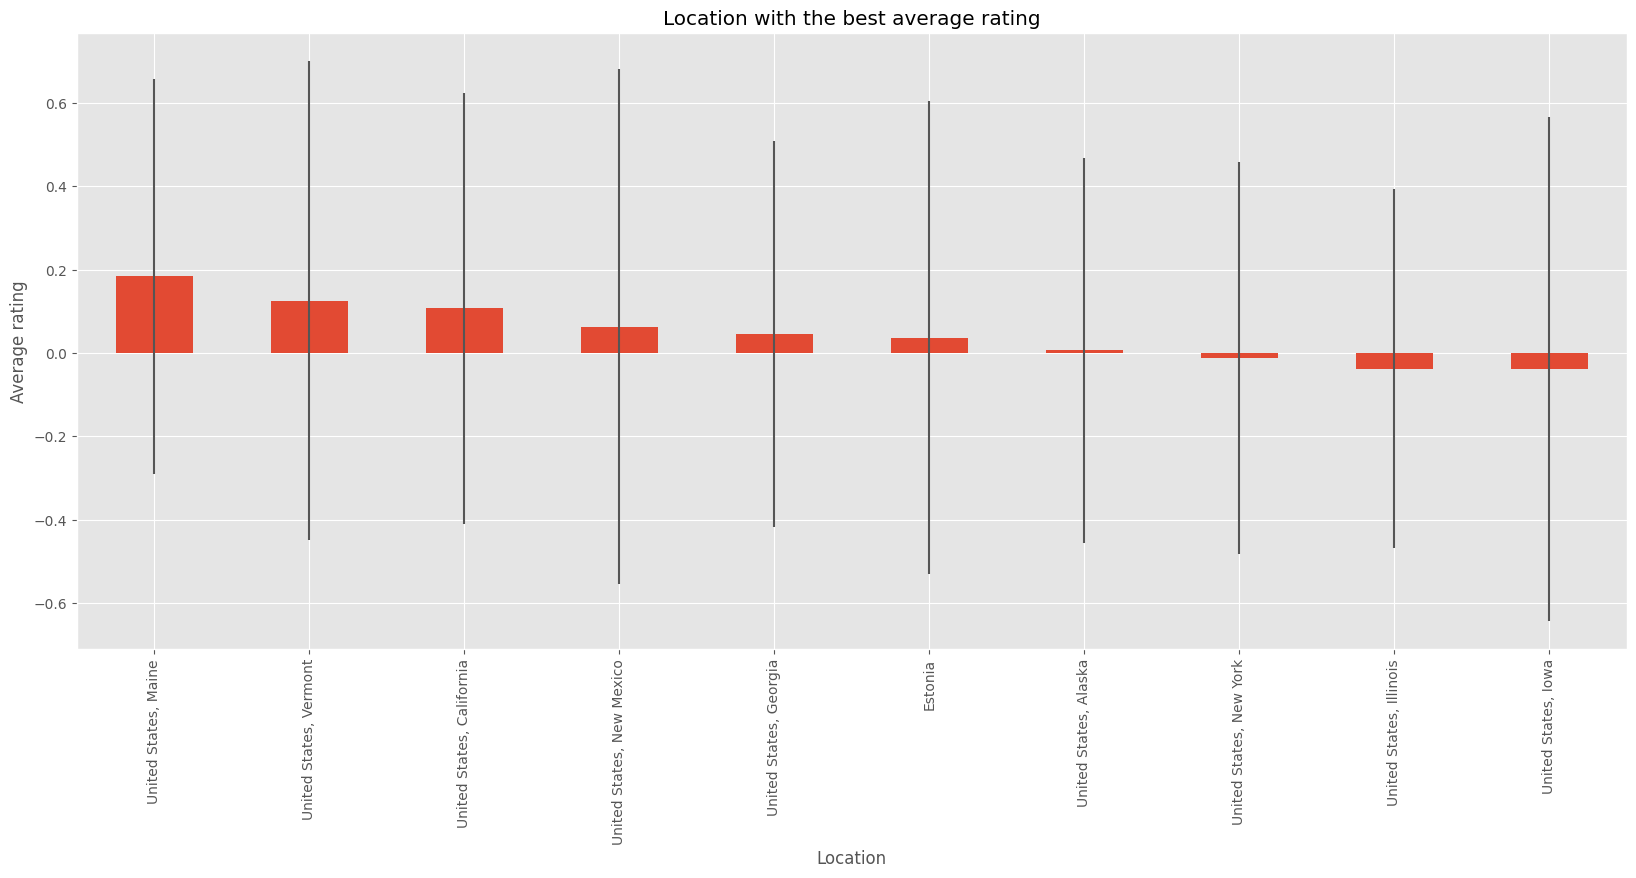

In [40]:
#Compute the beers'average rating on the two website by creating new columns
df_beer_breweries_flt['total_rating'] = df_beer_breweries_flt['nbr_ratings'] + df_beer_breweries_flt['nbr_ratings.1']
df_beer_breweries_flt['zscore_common'] = df_beer_breweries_flt['nbr_ratings']/df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore'] + df_beer_breweries_flt['nbr_ratings.1'] / df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore.1']


#Sort the dataframe by considering the 10 location with the best average rating
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_best = avg_rating_location.head(10)
display(top_ten_best)


#Plot the result with stndard deviation as error bar
pl = top_ten_best['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_best['std'])
pl.set_title('Location with the best average rating')
pl.set_ylabel('Average rating')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_best.index, rotation=90)

#Keep a copy the ranking 
top_ten_best_only_location = top_ten_best.index 



As we can see on the barplot above, the standard deviation in each location is quite huge. It shows that is a location, there are well-rated beers, but also some that are badly rated. The precision of this not good, but still give a good idea of the regions where the overall ratings of the beers is high.

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
India,9.0,-2.288825,0.872045,-3.551164,-2.801557,-2.365467,-1.955389,-0.715524
Turkey,8.0,-2.184292,0.723807,-3.099231,-2.641925,-2.092501,-1.892948,-0.877841
Trinidad & Tobago,7.0,-2.012406,1.132839,-2.687124,-2.611628,-2.351946,-2.164243,0.503969
Bahamas,6.0,-1.680188,0.737527,-2.177367,-2.150897,-2.010967,-1.549750,-0.288275
Philippines,5.0,-1.486746,0.499785,-1.788784,-1.770752,-1.681783,-1.588225,-0.604184
Faroe Islands,6.0,-1.463507,0.462709,-1.911502,-1.825751,-1.559192,-1.223854,-0.724477
Lithuania,23.0,-1.425476,0.630819,-2.724032,-1.868994,-1.269317,-0.941136,-0.392230
Cayman Islands,5.0,-1.403978,0.967026,-2.505088,-1.987803,-1.525055,-1.021435,0.019492
Taiwan,5.0,-1.201023,1.079984,-2.994090,-1.257439,-0.974745,-0.587663,-0.191180


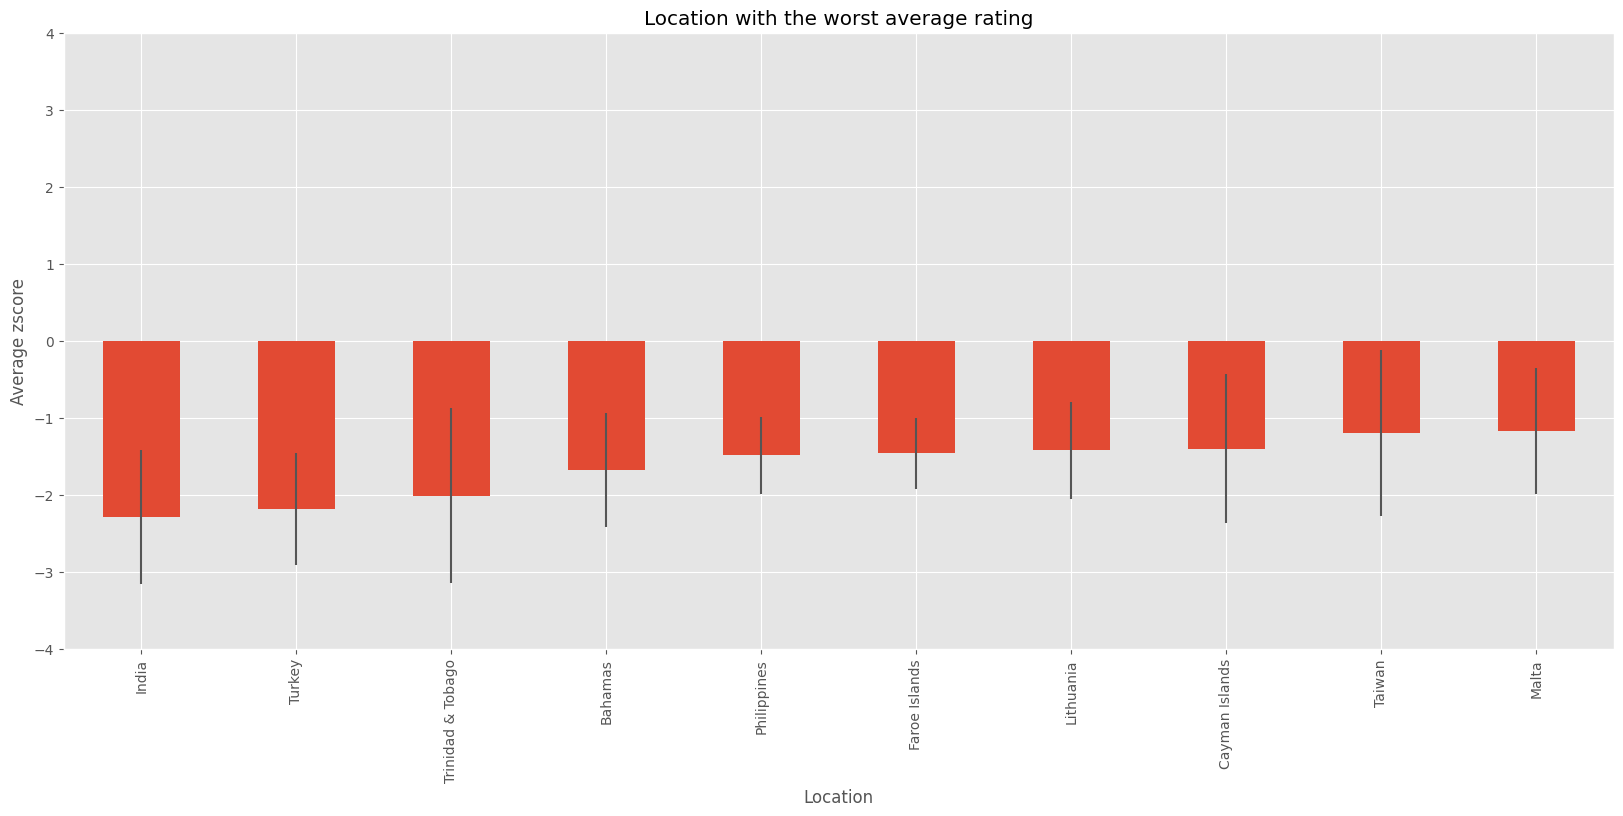

In [42]:
#Sorted the location considering the 10 location with the worst average rating and plot the result
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_worst = avg_rating_location.head(10)
display(top_ten_worst)


#Plot the result with stndard deviation as error bar
pl = top_ten_worst['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_worst['std'])
pl.set_title('Location with the worst average rating')
pl.set_ylabel('Average zscore')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_worst.index, rotation=90)
pl.set_ylim([-4, 4])

#Keep a copy the ranking 
top_ten_worst_only_location = top_ten_worst.index 


This part is more for fun, because we have access to the worst locations, so why not to have a look at it!


**BEER TRIP RELATIVELY TO THE NUMBER OF USERS**

This part is not finish yet, because we need to import a dataframe from Wikipedia with the population from every location in order to compute the amount of user per individual. Then we are going to rank the region of the world with respect to the ones having a lot of reviewers in the population (in those countries, you are more likely to find people that love beers !)

In [19]:
#To determine the locations where the population is the most passionate by beer. 
#We thought about computing the amount of reviewers per location relatively to the population of the location.
df_users_approx_flt


,location,user_id,user_name,nbr_ratings_beer_advocate,nbr_ratings_ratebeer
0,Spain,magicuenca.1185749,MAGICuenca,3,89
1,Germany,erzengel.248045,Erzengel,6,8781
2,"United States, Virginia",gendv138.695700,GenDV138,1,6240
3,"United States, Washington",nimbleprop.208928,nimbleprop,3,7452
4,Estonia,visionthing.639993,visionthing,11,5462
...,...,...,...,...,...
3336,"United States, Michigan",ypsifly.8833,ypsifly,587,1
3337,"United States, Texas",hardtarget.1712,HardTarget,1379,1
3338,"United States, Delaware",deadterry.13629,DeadTerry,1,2
3339,Vietnam,nelsonsaigon.897449,nelsonsaigon,176,1


**ILLUSTRATION OF THE TRIPS ON A MAP**

Not finish yet, it the part where we will show the trips given by each thematic. 
TO DO (for Milestone P3): 
We want to illustrate the trips relatively to the features on a map of the world to visualize well the steps of the trips. 

In [20]:
#new.location.apply(lambda x: x.split(', '))
tmp = df_beer_breweries_clean.groupby('location').size().reset_index(name='count')
new = df_beer_breweries_clean.groupby('location').avg.mean().reset_index().dropna()
#remove everything after the string United States, in the location coumn



#add the count column to the new df
new = pd.merge(new, tmp, on='location', how='left')
new = new[new['count'] > 5]

#sort new df by avg
new = new.sort_values(by=['avg'], ascending=False)

display(new, tmp)

,location,avg,count
66,Mauritius,4.950000,12
129,"United States, Maine",3.943314,363
50,Ireland,3.919448,167
155,"United States, Vermont",3.909731,699
142,"United States, New York",3.889848,1718
...,...,...,...
57,Laos,3.015000,6
70,Mozambique,2.920000,6
6,Bahamas,2.865000,6
106,Trinidad & Tobago,2.747500,8


,location,count
0,Albania,1
1,Algeria,4
2,Angola,1
3,Argentina,19
4,Australia,711
...,...,...
170,Vanuatu,2
171,Vietnam,19
172,Virgin Islands (U.S.),1
173,Wales,225


In [21]:
countries = json.load(open('../beer_data/custom.geo.json', 'r'))
countries_id_map = {}

for feature in countries['features']:
    feature['id'] = feature['properties']['name_long']
    countries_id_map[feature['properties']['name_long']] = feature['id']

new['id'] = new['location'].apply(lambda x: countries_id_map[x])

NameError: name 'json' is not defined

In [ ]:
fig =  px.choropleth(new, 
                     geojson=countries, # geojson file to use
                     locations="location", # which column to use to set the color of markers
                     color = 'avg', # color of markers can be a single color value or an iterable
                     projection="orthographic",
                     )


fig.show()

### Calculation of the overall ranking: 

This part is not finish yet, because we didn't build all the rankings (so we don't know how many weights we will need). But the idea is to ask couple questions to the customers in order to determine which rankings are important for them. Then, with respect to the answers given, we assign some weights in order to emphasize the importance of some rankings compare to the others. For the moment, we implement the function with 5 weights.

In [ ]:
#Compute the overall ranking based on the previous rankings (assume 10 rankings)
def overall_ranking(w1, w2, w3, w4, w5) :
    '''
    Plot the overall ranking based on the previous rankings and their respective weights, given by the customer. 
    The weights must be between 0 and 1 and must sum to 1.

    Args :
        w1 : weight of the ranking 1
        w2 : weight of the ranking 2
        w3 : weight of the ranking 3
        w4 : weight of the ranking 4
        w5 : weight of the ranking 5 
    '''
    # Add the point for each ranking 
    df_density_top10 = pd.DataFrame({'location': top_ten_density_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_bestratings_top10 = pd.DataFrame({'location': top_ten_best_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_worstratings_top10 = pd.DataFrame({'location': top_ten_worst_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})  
    df_strongest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_softest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})

    # Apply the weights to the score
    df_density_top10['score'] = df_density_top10['score'] * w1
    df_bestratings_top10['score'] = df_bestratings_top10['score'] * w2
    df_worstratings_top10['score'] = df_worstratings_top10['score'] * w3
    df_strongest_abv_top10['score'] = df_strongest_abv_top10['score'] * w4
    df_softest_abv_top10['score'] = df_softest_abv_top10['score'] * w5

    # Merge all the dataframes
    df_overall = pd.merge(df_density_top10, df_bestratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_worstratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_strongest_abv_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_softest_abv_top10, on='location', how='outer')


### TO DO : 
# change the number in Args (docstring) by the name of the rankings (ex : % of alcohol, density of breweries, etc)
# plot the overall ranking
# return a dataframe with the overall ranking location (only location, don't need the score anymore)


### Find additional useful travel informations: 

TO DO (for Milestone P3): 
After having the overall ranking, we need to find the best breweries (the ones with the best beers) in each location and also the best users (the ones with the most ratings)